   Running Deep Learning (Simple RNN) Model
   Scaler Type: Standard Scaler (Z-Score)
   Scaled File: Banthapchang_Scaled_Cyclical_Standard_FS_Departure
   Unscaled File: Banthapchang_NotScaled_Cyclical_Standard_FS_Departure
Loading and preprocessing data...
Statistics for Inverse Transform:
Mean: 2722.9962, Std: 1017.9506
Data Split: Train=734, Test=184

Starting Grid Search for RNN...
----------------------------------------------------------

[Progress 1/54] Testing Params: {'units': 32, 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.01}
  > Fold 1/5: Training... Done. (RMSE: 818.65)
  > Fold 2/5: Training... Done. (RMSE: 269.73)
  > Fold 3/5: Training... Done. (RMSE: 341.99)
  > Fold 4/5: Training... Done. (RMSE: 432.70)
  > Fold 5/5: Training... Done. (RMSE: 260.76)
  >>> Average RMSE for this set: 424.7667

[Progress 2/54] Testing Params: {'units': 32, 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.001}
  > Fold 1/5: Training... Done. (RMSE: 511.80)
  > Fold 2/5: Training

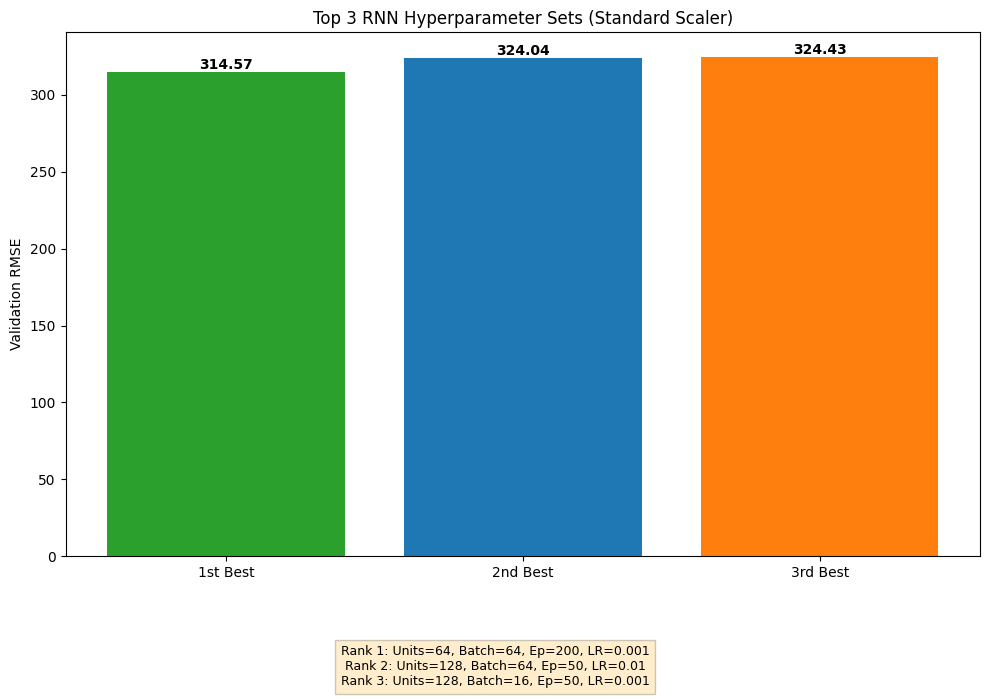


--- Top 3 Best Parameters ---
Rank 1: Units=64, Batch=64, Ep=200, LR=0.001
Rank 2: Units=128, Batch=64, Ep=50, LR=0.01
Rank 3: Units=128, Batch=16, Ep=50, LR=0.001

Retraining FINAL MODEL with Best Params
Params: {'units': 64, 'batch_size': 64, 'epochs': 200, 'learning_rate': 0.001}
Epoch 1/200
12/12 [==============================] - 1s 2ms/step - loss: 1.1828
Epoch 2/200
12/12 [==============================] - 0s 2ms/step - loss: 0.7745
Epoch 3/200
12/12 [==============================] - 0s 2ms/step - loss: 0.5712
Epoch 4/200
12/12 [==============================] - 0s 2ms/step - loss: 0.4160
Epoch 5/200
12/12 [==============================] - 0s 2ms/step - loss: 0.3347
Epoch 6/200
12/12 [==============================] - 0s 2ms/step - loss: 0.2764
Epoch 7/200
12/12 [==============================] - 0s 2ms/step - loss: 0.2412
Epoch 8/200
12/12 [==============================] - 0s 2ms/step - loss: 0.2269
Epoch 9/200
12/12 [==============================] - 0s 2ms/step - loss: 0.

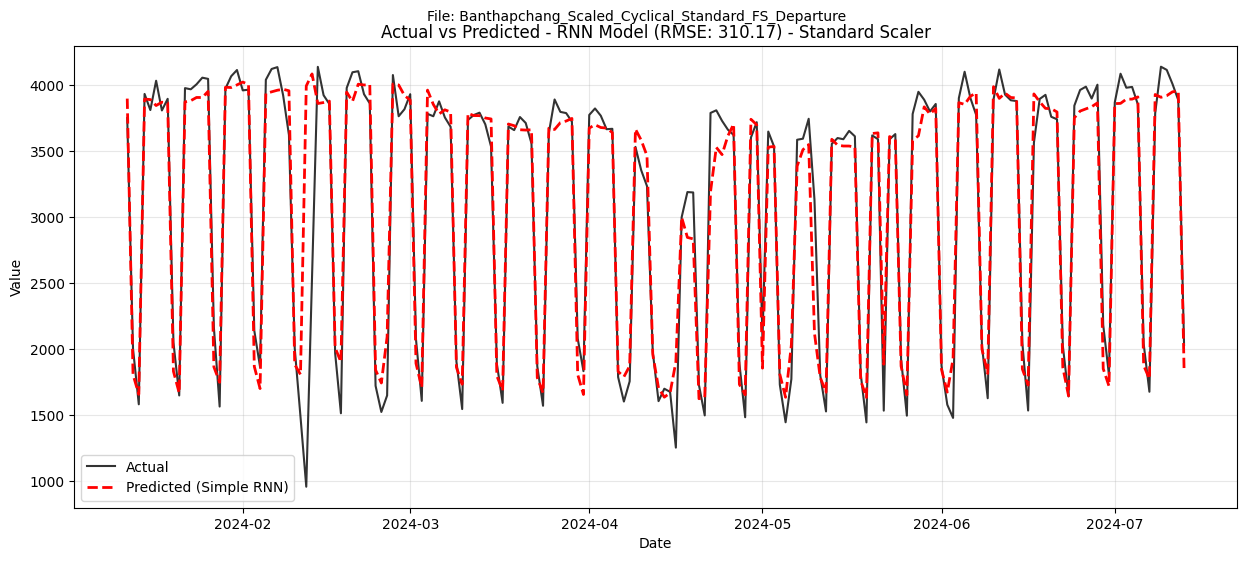

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
# เปลี่ยนจาก LSTM เป็น SimpleRNN
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import os
import random
import sys

# ตั้งค่า Seed เพื่อผลลัพธ์ที่เหมือนเดิม (Reproducibility)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# เปลี่ยนชื่อฟังก์ชันเป็น create_RNN_model
def create_RNN_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    """ฟังก์ชันสร้างโมเดล Simple RNN"""
    model = Sequential()
    

    model.add(SimpleRNN(units, input_shape=input_shape, activation='relu', return_sequences=False))
    
    model.add(Dropout(dropout_rate))
    # Output Layer (1 node สำหรับ Regression)
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# เปลี่ยนชื่อฟังก์ชันหลัก
def run_deep_learning_RNN(scaled_file, unscaled_file):
    set_seed(42)

    print(f"==========================================")
    print(f"   Running Deep Learning (Simple RNN) Model")
    print(f"   Scaler Type: Standard Scaler (Z-Score)")
    print(f"   Scaled File: {scaled_file[5:-4]}")
    print(f"   Unscaled File: {unscaled_file[5:-4]}")
    print(f"==========================================")

    # ---------------------------------------------------------
    # 1. Load Data & Preprocessing
    # ---------------------------------------------------------
    print("Loading and preprocessing data...")
    df_scaled = pd.read_csv(scaled_file)
    df_unscaled = pd.read_csv(unscaled_file)

    # แปลง Date และ Sort
    df_scaled['Date'] = pd.to_datetime(df_scaled['Date'])
    df_unscaled['Date'] = pd.to_datetime(df_unscaled['Date'])
    df_scaled = df_scaled.sort_values('Date').reset_index(drop=True)
    df_unscaled = df_unscaled.sort_values('Date').reset_index(drop=True)

    # Align Data
    common_dates = df_scaled['Date'][df_scaled['Date'].isin(df_unscaled['Date'])]
    df_scaled = df_scaled[df_scaled['Date'].isin(common_dates)].reset_index(drop=True)
    df_unscaled = df_unscaled[df_unscaled['Date'].isin(common_dates)].reset_index(drop=True)

    # ระบุ Target
    target_col_scaled = df_scaled.columns[1]
    target_col_unscaled = df_unscaled.columns[1]

    # เตรียม X, y
    X = df_scaled.drop(columns=['Date', target_col_scaled]).values
    y = df_scaled[target_col_scaled].values

    # เตรียมค่า Mean/Std สำหรับ Inverse Transform
    y_mean = df_unscaled[target_col_unscaled].mean()
    y_std = df_unscaled[target_col_unscaled].std()
    
    print(f"Statistics for Inverse Transform:")
    print(f"Mean: {y_mean:.4f}, Std: {y_std:.4f}")

    # เตรียม y_real_full
    y_real_full = df_unscaled[target_col_unscaled].values

    # Reshape X สำหรับ RNN: [Samples, TimeSteps, Features]
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # ---------------------------------------------------------
    # 2. Train-Test Split (80:20 Time Series)
    # ---------------------------------------------------------
    train_size = int(len(X) * 0.8)
    X_train_full, X_test = X[:train_size], X[train_size:]
    y_train_full, y_test = y[:train_size], y[train_size:]

    # เก็บค่าจริงของ Test Set ไว้เทียบผล
    y_test_real = y_real_full[train_size:]
    test_dates = df_unscaled['Date'].iloc[train_size:]

    print(f"Data Split: Train={X_train_full.shape[0]}, Test={X_test.shape[0]}")

    # ---------------------------------------------------------
    # 3. Grid Search
    # ---------------------------------------------------------
    print("\nStarting Grid Search for RNN...")
    print("----------------------------------------------------------")

    # กำหนด Parameter Grid
    param_grid = {
        'units': [32, 64, 128],
        'batch_size': [16, 32, 64],
        'epochs': [50, 100, 200],
        'learning_rate': [0.01, 0.001]
    }

    import itertools
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    total_combinations = len(param_combinations)

    tscv = TimeSeriesSplit(n_splits=5)
    results = []

    for i, params in enumerate(param_combinations):
        print(f"\n[Progress {i+1}/{total_combinations}] Testing Params: {params}")

        fold_rmses = []

        for fold_idx, (train_index, val_index) in enumerate(tscv.split(X_train_full)):
            print(f"  > Fold {fold_idx+1}/5: Training...", end=' ')
            sys.stdout.flush()

            X_cv_train, X_cv_val = X_train_full[train_index], X_train_full[val_index]
            y_cv_train, y_cv_val = y_train_full[train_index], y_train_full[val_index]

            # เรียกใช้ฟังก์ชัน create_RNN_model
            model = create_RNN_model(
                input_shape=(X_cv_train.shape[1], X_cv_train.shape[2]),
                units=params['units'],
                learning_rate=params['learning_rate']
            )

            model.fit(X_cv_train, y_cv_train,
                      epochs=params['epochs'],
                      batch_size=params['batch_size'],
                      verbose=0,
                      shuffle=False)

            # Predict & Evaluate
            pred_scaled = model.predict(X_cv_val, verbose=0)

            # Inverse Transform
            pred_real = pred_scaled * y_std + y_mean
            actual_real = y_cv_val * y_std + y_mean

            rmse = np.sqrt(mean_squared_error(actual_real, pred_real))
            fold_rmses.append(rmse)

            print(f"Done. (RMSE: {rmse:.2f})")

        avg_rmse = np.mean(fold_rmses)
        results.append({'params': params, 'rmse': avg_rmse})
        print(f"  >>> Average RMSE for this set: {avg_rmse:.4f}")

    # ---------------------------------------------------------
    # 4. Analyze Top 3 Parameters
    # ---------------------------------------------------------
    print("\nAnalyzing Top 3 Results...")
    results_df = pd.DataFrame(results).sort_values('rmse')
    top_3 = results_df.head(3)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(3), top_3['rmse'], color=['#2ca02c', '#1f77b4', '#ff7f0e'])
    plt.xticks(range(3), ['1st Best', '2nd Best', '3rd Best'])
    plt.ylabel('Validation RMSE')
    plt.title('Top 3 RNN Hyperparameter Sets (Standard Scaler)')

    param_texts = []
    for idx, (i, row) in enumerate(top_3.iterrows()):
        height = row['rmse']
        plt.text(idx, height, f"{height:.2f}", ha='center', va='bottom', fontweight='bold')

        p = row['params']
        p_str = f"Rank {idx+1}: Units={p['units']}, Batch={p['batch_size']}, Ep={p['epochs']}, LR={p['learning_rate']}"
        param_texts.append(p_str)

    plt.figtext(0.5, -0.15, "\n".join(param_texts), ha="center", fontsize=9, bbox={"facecolor":"orange", "alpha":0.2})
    plt.tight_layout()
    plt.show()

    print("\n--- Top 3 Best Parameters ---")
    for txt in param_texts:
        print(txt)

    # ---------------------------------------------------------
    # 5. Final Training with Best Params
    # ---------------------------------------------------------
    best_params = top_3.iloc[0]['params']
    print(f"\n==========================================")
    print(f"Retraining FINAL MODEL with Best Params")
    print(f"Params: {best_params}")
    print(f"==========================================")

    # เรียกใช้ฟังก์ชัน create_RNN_model
    final_model = create_RNN_model(
        input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
        units=best_params['units'],
        learning_rate=best_params['learning_rate']
    )

    history = final_model.fit(X_train_full, y_train_full,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1,
                    shuffle=False)

    # ---------------------------------------------------------
    # 6. Final Prediction & Metrics
    # ---------------------------------------------------------
    print("\nEvaluating on Test Set...")
    y_pred_scaled = final_model.predict(X_test)

    # Inverse Transform
    y_pred_real = y_pred_scaled * y_std + y_mean
    y_pred_real = y_pred_real.flatten()

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae = mean_absolute_error(y_test_real, y_pred_real)
    mape = mean_absolute_percentage_error(y_test_real, y_pred_real)

    print(f"\n--- Final Test Set Evaluation ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    # ---------------------------------------------------------
    # 7. Plot Actual vs Predicted
    # ---------------------------------------------------------
    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, y_test_real, label='Actual', color='black', alpha=0.8)
    plt.plot(test_dates, y_pred_real, label='Predicted (Simple RNN)', color='red', linestyle='--', linewidth=2)
    plt.title(f'Actual vs Predicted - RNN Model (RMSE: {rmse:.2f}) - Standard Scaler')
    plt.suptitle(f'File: {scaled_file[5:-4]}', y=0.94, fontsize=10)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    results = pd.DataFrame({
        'Units': [best_params['units']],
        'Batch_Size': [best_params['batch_size']],
        'Epochs': [best_params['epochs']],
        'Learning_Rate': [best_params['learning_rate']],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape]
    })
    
    # Save results เปลี่ยนชื่อไฟล์เป็น RNN
    results.to_csv(f'RNN_Results_{scaled_file[5:-4]}.csv', index=False)

# ========================================================
# ส่วนกำหนดค่าเริ่มต้น (Configuration)
# ========================================================
if __name__ == "__main__":
    
    # Path ไฟล์ข้อมูล (ปรับให้ตรงกับเครื่องของคุณ)
    scaled_file_path = r'data\Banthapchang_Scaled_Cyclical_Standard_FS_Departure.csv'
    unscaled_file_path = r'data\Banthapchang_NotScaled_Cyclical_Standard_FS_Departure.csv'

    # รันโปรแกรม (เรียกฟังก์ชัน RNN)
    if os.path.exists(scaled_file_path) and os.path.exists(unscaled_file_path):
        run_deep_learning_RNN(scaled_file_path, unscaled_file_path)
    else:
        print("ไม่พบไฟล์ข้อมูล กรุณาตรวจสอบ path ในส่วน if __name__ == '__main__':")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import os
import random
import warnings

# ปิด Warning ของ TF และ System
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# ตั้งค่า Seed เพื่อผลลัพธ์ที่เหมือนเดิม
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def create_RNN_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    """ฟังก์ชันสร้างโมเดล Simple RNN"""
    model = Sequential()
    # Input Layer (ระบุ shape ให้ชัดเจน)
    model.add(Input(shape=input_shape))
    # SimpleRNN Layer
    model.add(SimpleRNN(units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    # Output Layer
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def run_rnn_model(station_name, direction, base_path='data'):
    # ตั้งชื่อไฟล์ Scaled (สำหรับ Train) และ Unscaled (สำหรับอ้างอิงค่าจริง)
    file_scaled = f"{station_name}_{direction}_RFECV_Selected.csv"
    file_unscaled = f"{station_name}_{direction}_RFECV_Unscaled.csv"
    
    path_scaled = os.path.join(base_path, file_scaled)
    path_unscaled = os.path.join(base_path, file_unscaled)

    print(f"\n{'='*60}")
    print(f" Processing RNN: {station_name} - {direction}")
    print(f"{'='*60}")

    if not os.path.exists(path_scaled) or not os.path.exists(path_unscaled):
        print(f"Error: One or both files not found.")
        return None, None

    # ---------------------------------------------------------
    # 1. Load Data
    # ---------------------------------------------------------
    # โหลดข้อมูล Scaled
    df_scaled = pd.read_csv(path_scaled)
    df_scaled['Date'] = pd.to_datetime(df_scaled['Date'])
    df_scaled = df_scaled.sort_values('Date').reset_index(drop=True)

    # โหลดข้อมูล Unscaled
    df_unscaled = pd.read_csv(path_unscaled)
    df_unscaled['Date'] = pd.to_datetime(df_unscaled['Date'])
    df_unscaled = df_unscaled.sort_values('Date').reset_index(drop=True)

    # --- แก้ไขจุดที่ Error ---
    # แยกตัวแปรชื่อคอลัมน์ของใครของมัน (Index 3)
    target_col_scaled = df_scaled.columns[3]      # ชื่อในไฟล์ Scaled
    target_col_unscaled = df_unscaled.columns[3]  # ชื่อในไฟล์ Unscaled (ที่ถูกต้อง)
    
    print(f"Target (Scaled): {target_col_scaled}")
    print(f"Target (Real):   {target_col_unscaled}")

    # ดึงค่าจริงจากไฟล์ Unscaled โดยใช้ชื่อคอลัมน์ของไฟล์ Unscaled เอง
    real_target_values = df_unscaled[target_col_unscaled].values
    target_mean = np.mean(real_target_values)
    target_std = np.std(real_target_values)

    # เตรียม X, y จากไฟล์ Scaled
    cols_to_drop = ['Date', target_col_scaled] # ลบ column target ของไฟล์ scaled
    for col in df_scaled.columns:
        if 'train' in col.lower(): cols_to_drop.append(col)

    X = df_scaled.drop(columns=cols_to_drop, errors='ignore')
    X = X.select_dtypes(include=[np.number]).values
    y = df_scaled[target_col_scaled].values # ใช้ target ของไฟล์ scaled

    # Reshape X สำหรับ RNN
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # ---------------------------------------------------------
    # 2. Train-Test Split (80:20)
    # ---------------------------------------------------------
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test_scaled = y[:train_size], y[train_size:]
    
    test_dates = df_scaled['Date'].iloc[train_size:]
    
    # ใช้ค่าจริงจากไฟล์ Unscaled มาเป็น y_test สำหรับวัดผล
    y_test_real = df_unscaled[target_col_unscaled].iloc[train_size:].values

    # ---------------------------------------------------------
    # 3. Manual Grid Search
    # ---------------------------------------------------------
    param_grid = {
        'units': [32, 64, 128],
        'batch_size': [16, 32, 64],
        'epochs': [50, 100, 200],
        'learning_rate': [0.01, 0.001]
    }
    
    grid = list(ParameterGrid(param_grid))
    
    best_score = float('inf')
    best_params = None
    
    # ลด n_splits เหลือ 2 เพื่อให้เร็วขึ้นสำหรับการทดสอบแก้บั๊ก
    tscv = TimeSeriesSplit(n_splits=2) 

    print(f"Starting Grid Search ({len(grid)} combinations)...")

    for i, params in enumerate(grid):
        print(f"  Testing {i+1}/{len(grid)}: {params}", end='\r')
        
        cv_scores = []
        for train_index, val_index in tscv.split(X_train):
            X_cv_train, X_cv_val = X_train[train_index], X_train[val_index]
            y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
            
            set_seed(42)
            model = create_RNN_model(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                units=params['units'],
                learning_rate=params['learning_rate']
            )
            
            model.fit(
                X_cv_train, y_cv_train,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                verbose=0,
                shuffle=False
            )
            
            pred_scaled = model.predict(X_cv_val, verbose=0)
            mse = mean_squared_error(y_cv_val, pred_scaled)
            cv_scores.append(np.sqrt(mse))
        
        mean_cv_score = np.mean(cv_scores)
        
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_params = params

    print(f"\nBest Params: {best_params} (CV RMSE: {best_score:.4f})")

    # ---------------------------------------------------------
    # 4. Final Training
    # ---------------------------------------------------------
    set_seed(42)
    final_model = create_RNN_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        units=best_params['units'],
        learning_rate=best_params['learning_rate']
    )
    
    final_model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        shuffle=False
    )
    
    y_pred_scaled = final_model.predict(X_test, verbose=0)
    
    # ---------------------------------------------------------
    # 5. Inverse Transform (แปลงกลับเป็นค่าจริง)
    # ---------------------------------------------------------
    # สูตร: Actual = (Scaled * Std) + Mean
    y_pred_real = (y_pred_scaled.flatten() * target_std) + target_mean
    y_pred_real = np.maximum(y_pred_real, 0)

    # เทียบกับ y_test_real (ค่าจริงจากไฟล์ Unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae = mean_absolute_error(y_test_real, y_pred_real)
    mape = mean_absolute_percentage_error(y_test_real, y_pred_real)

    print(f"Finished. Test RMSE: {rmse:.4f}")

    # ---------------------------------------------------------
    # 6. Plot & Save
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(test_dates, y_test_real, label='Actual', color='black', alpha=0.8)
    plt.plot(test_dates, y_pred_real, label='Predicted (RNN)', color='green', linestyle='--', linewidth=2)
    plt.title(f'RNN Prediction: {station_name} ({direction})\nRMSE: {rmse:.2f} | MAE: {mae:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Value (Real Scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if not os.path.exists('plots_predict_rnn'):
        os.makedirs('plots_predict_rnn')

    plt.savefig(f'plots_predict_rnn/Pred_{station_name}_{direction}.png')
    plt.close()

    summary_dict = {
        'Station': station_name,
        'Direction': direction,
        'units': best_params['units'],
        'batch_size': best_params['batch_size'],
        'epochs': best_params['epochs'],
        'learning_rate': best_params['learning_rate'],
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }
    
    grid_results = pd.DataFrame([best_params])
    grid_results['Station'] = station_name
    grid_results['Direction'] = direction
    grid_results['Best_CV_Score_Scaled'] = best_score
    
    return summary_dict, grid_results
    # ตั้งชื่อไฟล์ Scaled (สำหรับ Train) และ Unscaled (สำหรับอ้างอิงค่าจริง)
    file_scaled = f"{station_name}_{direction}_RFECV_Selected.csv"
    file_unscaled = f"{station_name}_{direction}_RFECV_Unscaled.csv"
    
    path_scaled = os.path.join(base_path, file_scaled)
    path_unscaled = os.path.join(base_path, file_unscaled)

    print(f"\n{'='*60}")
    print(f" Processing RNN: {station_name} - {direction}")
    print(f"{'='*60}")

    # เช็คว่าไฟล์อยู่ครบไหม
    if not os.path.exists(path_scaled) or not os.path.exists(path_unscaled):
        print(f"Error: One or both files not found.")
        print(f"Scaled: {path_scaled}")
        print(f"Unscaled: {path_unscaled}")
        return None, None

    # ---------------------------------------------------------
    # 1. Load Data
    # ---------------------------------------------------------
    # โหลดข้อมูล Scaled
    df_scaled = pd.read_csv(path_scaled)
    df_scaled['Date'] = pd.to_datetime(df_scaled['Date'])
    df_scaled = df_scaled.sort_values('Date').reset_index(drop=True)

    # โหลดข้อมูล Unscaled (เพื่อเอาค่า Mean/Std ของ Target)
    df_unscaled = pd.read_csv(path_unscaled)
    df_unscaled['Date'] = pd.to_datetime(df_unscaled['Date'])
    df_unscaled = df_unscaled.sort_values('Date').reset_index(drop=True)

    # กำหนด Target Column (สมมติเป็นคอลัมน์ index 3)
    target_col = df_scaled.columns[3] 
    
    # คำนวณ Mean และ Std ของ Target จริง (จากไฟล์ Unscaled) เพื่อใช้ Inverse Transform
    # สูตร Standard Scaler: z = (x - u) / s  =>  x = z * s + u
    real_target_values = df_unscaled[target_col].values
    target_mean = np.mean(real_target_values)
    target_std = np.std(real_target_values)

    # เตรียม X, y จากไฟล์ Scaled
    cols_to_drop = ['Date', target_col]
    for col in df_scaled.columns:
        if 'train' in col.lower(): cols_to_drop.append(col)

    X = df_scaled.drop(columns=cols_to_drop, errors='ignore')
    X = X.select_dtypes(include=[np.number]).values
    y = df_scaled[target_col].values

    # Reshape X สำหรับ RNN [samples, time_steps, features]
    # เรามอง 1 row เป็น 1 time_step (เนื่องจากเราทำ Lag Feature มาแล้ว)
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # ---------------------------------------------------------
    # 2. Train-Test Split (80:20)
    # ---------------------------------------------------------
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test_scaled = y[:train_size], y[train_size:]
    
    # วันที่สำหรับ Plot
    test_dates = df_scaled['Date'].iloc[train_size:]
    # ค่าจริง (Unscaled) สำหรับเทียบผล
    y_test_real = df_unscaled[target_col].iloc[train_size:].values

    # ---------------------------------------------------------
    # 3. Manual Grid Search (Custom Loop)
    # ---------------------------------------------------------
    param_grid = {
        'units': [32, 64, 128],
        'batch_size': [16, 32, 64],
        'epochs': [50, 100, 200],
        'learning_rate': [0.01, 0.001]
    }
    
    # สร้าง List ของ parameter ทั้งหมด
    grid = list(ParameterGrid(param_grid))
    
    best_score = float('inf')
    best_params = None
    best_model = None
    
    tscv = TimeSeriesSplit(n_splits=3) # ลด split ลงหน่อยเพื่อความเร็ว (RNN นาน)

    print(f"Starting Grid Search with {len(grid)} combinations...")

    # Loop ลองทุก Parameter
    for i, params in enumerate(grid):
        print(f"  Testing {i+1}/{len(grid)}: {params}", end='\r')
        
        cv_scores = []
        
        # Cross Validation Loop
        for train_index, val_index in tscv.split(X_train):
            X_cv_train, X_cv_val = X_train[train_index], X_train[val_index]
            y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
            
            set_seed(42) # Reset Seed ทุกครั้ง
            model = create_RNN_model(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                units=params['units'],
                learning_rate=params['learning_rate']
            )
            
            model.fit(
                X_cv_train, y_cv_train,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                verbose=0,
                shuffle=False
            )
            
            # Predict & Evaluate (ใน Scale)
            pred_scaled = model.predict(X_cv_val, verbose=0)
            mse = mean_squared_error(y_cv_val, pred_scaled)
            cv_scores.append(np.sqrt(mse)) # ใช้ RMSE เป็นเกณฑ์
        
        mean_cv_score = np.mean(cv_scores)
        
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_params = params

    print(f"\nBest Params found: {best_params} (CV RMSE Scaled: {best_score:.4f})")

    # ---------------------------------------------------------
    # 4. Final Training & Prediction
    # ---------------------------------------------------------
    # เทรนใหม่ด้วยข้อมูล Train ทั้งหมด + Best Params
    set_seed(42)
    final_model = create_RNN_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        units=best_params['units'],
        learning_rate=best_params['learning_rate']
    )
    
    history = final_model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        shuffle=False
    )
    
    # ทำนายผล (ได้ค่า Scaled)
    y_pred_scaled = final_model.predict(X_test, verbose=0)
    
    # ---------------------------------------------------------
    # 5. Inverse Transform (แปลงกลับเป็นค่าจริง)
    # ---------------------------------------------------------
    # สูตร: Actual = (Scaled * Std) + Mean
    y_pred_real = (y_pred_scaled.flatten() * target_std) + target_mean
    
    # ป้องกันค่าติดลบ (ถ้าเป็นข้อมูลปริมาณคน/ของ)
    y_pred_real = np.maximum(y_pred_real, 0)

    # คำนวณ Error กับค่าจริง (Unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae = mean_absolute_error(y_test_real, y_pred_real)
    mape = mean_absolute_percentage_error(y_test_real, y_pred_real)

    print(f"Finished. Test RMSE (Real Scale): {rmse:.4f}")

    # ---------------------------------------------------------
    # 6. Plot & Save
    # ---------------------------------------------------------
    if direction == 'Departure':
        plt.figure(figsize=(12, 5))
        plt.plot(test_dates, y_test_real, label='Actual', color='black', alpha=0.8)
        plt.plot(test_dates, y_pred_real, label='Predicted (RNN)', color='red', linestyle='--', linewidth=2)
        plt.title(f'RNN Prediction: {station_name} ({direction})\nRMSE: {rmse:.2f} | MAE: {mae:.2f}')
        plt.xlabel('Date')
    else:
        plt.figure(figsize=(12, 5))
        plt.plot(test_dates, y_test_real, label='Actual', color='black', alpha=0.8)
        plt.plot(test_dates, y_pred_real, label='Predicted (RNN)', color='blue', linestyle='--', linewidth=2)
        plt.title(f'RNN Prediction: {station_name} ({direction})\nRMSE: {rmse:.2f} | MAE: {mae:.2f}')
        plt.xlabel('Date')
    plt.ylabel('Value (Real Scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if not os.path.exists('plots_predict_rnn'):
        os.makedirs('plots_predict_rnn')

    plt.savefig(f'plots_predict_rnn/Pred_{station_name}_{direction}.png')
    plt.close()

    # เตรียมผลลัพธ์ส่งกลับ
    summary_dict = {
        'Station': station_name,
        'Direction': direction,
        'units': best_params['units'],
        'batch_size': best_params['batch_size'],
        'epochs': best_params['epochs'],
        'learning_rate': best_params['learning_rate'],
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # สร้าง Grid Results คร่าวๆ (เนื่องจาก Loop เองไม่ได้เก็บละเอียดเท่า sklearn)
    # ในที่นี้จะคืนค่าเฉพาะ Best Parameter กลับไปเพื่อบันทึก
    grid_results = pd.DataFrame([best_params])
    grid_results['Station'] = station_name
    grid_results['Direction'] = direction
    grid_results['Best_CV_Score_Scaled'] = best_score
    
    return summary_dict, grid_results

# ========================================================
# Main Loop Setup
# ========================================================
if __name__ == "__main__":
    
    stations = [
        'Suvarnabhumi', 'Ratchaprarop', 'Makkasan', 'Ladkrabang',
        'Ramkhamhaeng', 'Phayathai', 'Banthapchang', 'Huamak'
    ]
    
    directions = ['Arrival', 'Departure']
    
    all_summary = []
    
    print("Starting Batch Process with SimpleRNN...")
    print("Note: Grid Search for Neural Networks may take time.")
    
    for station in stations:
        for direction in directions:
            try:
                summary, _ = run_rnn_model(station, direction)
                
                if summary is not None:
                    all_summary.append(summary)
                    
            except Exception as e:
                print(f"!!! Error processing {station} {direction}: {e}")
                import traceback
                traceback.print_exc()

    # บันทึกไฟล์สรุป
    if all_summary:
        summary_df = pd.DataFrame(all_summary)
        summary_df.to_csv('All_Stations_RNN_Summary.csv', index=False)
        print(f"\nSummary saved to 'All_Stations_RNN_Summary.csv'")

Starting Batch Process with SimpleRNN...
Note: Grid Search for Neural Networks may take time.

 Processing RNN: Suvarnabhumi - Arrival
Target (Scaled): Passenger_Arrival_Scaled
Target (Real):   Passenger_Arrival_Filled
Starting Grid Search (54 combinations)...
  Testing 54/54: {'batch_size': 64, 'epochs': 200, 'learning_rate': 0.001, 'units': 128}
Best Params: {'batch_size': 32, 'epochs': 200, 'learning_rate': 0.001, 'units': 64} (CV RMSE: 0.2862)
Finished. Test RMSE: 967.5876

 Processing RNN: Suvarnabhumi - Departure
Target (Scaled): Passenger_Departure_Scaled
Target (Real):   Passenger_Departure_Filled
Starting Grid Search (54 combinations)...


KeyboardInterrupt: 